<a href="https://colab.research.google.com/github/lilfetz22/Running_data/blob/master/Running_Log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Running Log Analysis**

###Goals


By 9/17 - complete pre-Garmin Data Wrangling
1. check for any remaining information in Notes columns - done (9/17)
2. Fix Date column and fill it in and make it agree with weekday (10/1)
3. remove excess columns (10/5)

By 10/1 - Complete post-Garmin analysis
1. Data Wrangling

    a. filtering out activities from one another 

    b. comparing overlap from pre-garmin to post-Garmin records and fill in missing data

# Pre-Garmin Data Wrangling

In [2]:
import pandas as pd
import re
import numpy as np
import math
import calendar
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
def findall_n_join_fx(df, note_col, new_col, search_string):
    df.loc[:,new_col] = df.loc[:,note_col].str.findall(search_string)
    df.loc[:,new_col] = df.loc[:,new_col].str.join('')
    df.loc[:,note_col] = df.loc[:,note_col].str.replace(search_string, '')
    return df

In [196]:
log_csv = pd.read_csv("/content/drive/My Drive/pre-garmin.csv",encoding='windows-1254')
log_csv.head(15)

,Running log 6/21/10,3/17/14,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Saturday 5/29/10,NaN,4 miles 27:19 it was a little short. 3.8 miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Monday 6/21/10,4 miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tuesday 6/22/10,4 miles,Swimming,10 laps of freestyle,5 laps of backstroke,5,laps of breaststroke,NaN,1 lap all out of freestyle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wednesday 6/23/10,4.5 miles,35 minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Thursday 6/25/10,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Friday 6/26/10,5,Swimming,same as Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Saturday 6/27/10,6,41:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Monday 6/28/10,4,28:04:00,5 total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tuesday 6/29/10,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
log_csv.tail()

,Running log 6/21/10,3/17/14,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
1979,TOTAL - 48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980,Monday - 12/21/15 - off,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981,Tuesday - I've failed. Not going to be able to...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,Thursday - 12/25/15 - 3 miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,Thursday - 12/31/15 - 30 minutes biking - 9.5 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creation of Raw string before manipulation of columns

In [198]:
log_csv.columns

Index(['Running log 6/21/10 ', ' 3/17/14', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17'],
      dtype='object')

In [199]:
raw_string = log_csv.copy()
raw_string['raw_note'] = raw_string['Running log 6/21/10 '].str.cat(raw_string[[' 3/17/14','Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7',
                                                     'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11','Unnamed: 12',
                                                     'Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16','Unnamed: 17']].astype(str), sep="_")
raw_string2 = raw_string[['raw_note']]
raw_string2.loc[:, 'raw_note'] = raw_string2.loc[:, 'raw_note'].str.replace('_?nan_?', '')
raw_string2.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,raw_note
0,Saturday 5/29/10 4 miles 27:19 it was a little...
1,Monday 6/21/10_ 4 miles
2,Tuesday 6/22/10_ 4 miles_Swimming_ 10 laps of ...
3,Wednesday 6/23/10_ 4.5 miles_35 minutes
4,Thursday 6/25/10_ 5


In [200]:
log_csv['Notes'] = log_csv['Unnamed: 2'].str.cat(log_csv[['Unnamed: 3', 'Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7',
                                                     'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11','Unnamed: 12',
                                                     'Unnamed: 13','Unnamed: 14','Unnamed: 15','Unnamed: 16','Unnamed: 17']].astype(str), sep="_")
log_csv2 = log_csv[['Running log 6/21/10 ',' 3/17/14','Notes']]
log_csv2.head(10)

,Running log 6/21/10,3/17/14,Notes
0,Saturday 5/29/10,NaN,4 miles 27:19 it was a little short. 3.8 mile...
1,Monday 6/21/10,4 miles,NaN
2,Tuesday 6/22/10,4 miles,Swimming_ 10 laps of freestyle_5 laps of backs...
3,Wednesday 6/23/10,4.5 miles,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...
4,Thursday 6/25/10,5,NaN
5,Friday 6/26/10,5,Swimming_ same as Tuesday_nan_nan_nan_nan_nan_...
6,Saturday 6/27/10,6,41:04_nan_nan_nan_nan_nan_nan_nan_nan_nan_nan...
7,NaN,NaN,NaN
8,Monday 6/28/10,4,28:04:00_5 total_nan_nan_nan_nan_nan_nan_nan_n...
9,Tuesday 6/29/10,5,NaN


In [201]:
# columns = ['Weekday', 'Date', 'Mileage', 'Minutes', 'Notes']
log_csv2.columns = ['Beginning', 'Mileage', 'Notes']

In [202]:
m = '- 7 miles - warmup with maggie - 82.190 - 6:19:16 - 13.0 avg'
t = '- 8 miles - thanksgiving 18.229 mile'
e = '35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan'
re.sub('_nan', '', e)

'35 minutes'

In [203]:
findall_n_join_fx(log_csv2, 'Beginning', 'Weekday', '\w+day')
log_csv2 = findall_n_join_fx(log_csv2, 'Beginning', 'Date', '\d+/\d+/\d\d')
log_csv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Beginning  1966 non-null   object
 1   Mileage    1217 non-null   object
 2   Notes      751 non-null    object
 3   Weekday    1966 non-null   object
 4   Date       1966 non-null   object
dtypes: object(5)
memory usage: 77.6+ KB


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [204]:
log_csv3 = log_csv2[log_csv2['Beginning'].str.startswith('TOTAL') == False]

In [205]:
log_csv3.loc[:,'Mileage_init'] = log_csv3.loc[:,'Beginning'].str.findall('\d+\.*\d*')
log_csv3.loc[:, 'length'] = log_csv3['Mileage_init'].str.len()
log_csv3['counter'] = range(len(log_csv3))
log_csv3['Workout_mins'] = np.nan
log_csv3['Swimming_meters'] = np.nan
log_csv3['Bike_Mileage'] = np.nan
log_csv3 = log_csv3.rename(columns = {'Beginning': 'Notes2'})
check_data = log_csv3[log_csv3.length >1]
check_data2 = check_data[['Notes2','Mileage','Mileage_init','counter']]
len(check_data2)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

157

#### Manipulations

In [206]:
log_csv3.iloc[1138,5] = np.nan
log_csv3.iloc[1206,5] = np.nan
log_csv3.iloc[1431,5] = np.nan
log_csv3.iloc[1432,5] = np.nan
log_csv3.iloc[1527,5] = np.nan
log_csv3.iloc[1561,5] = np.nan
log_csv3.iloc[1596,5] = np.nan
log_csv3.iloc[1614,5] = np.nan
log_csv3.iloc[1632,5] = np.nan
log_csv3.iloc[1648,5] = np.nan
log_csv3.iloc[1316,5] = np.nan

#### New Log

In [207]:
log_csv3.to_csv("/content/drive/My Drive/mileage_manip2.csv")

In [369]:
new_log = pd.read_csv("/content/drive/My Drive/mileage_manip2.csv",index_col=0)
new_log.head(10)

,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_mins,Swimming_meters,Bike_Mileage
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,[],0,0,NaN,NaN,NaN
1,,4 miles,NaN,Monday,6/21/10,[],0,1,NaN,NaN,NaN
2,,4 miles,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,[],0,2,NaN,NaN,NaN
3,,4.5 miles,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,[],0,3,NaN,NaN,NaN
4,,5,NaN,Thursday,6/25/10,[],0,4,NaN,NaN,NaN
5,,5,Swimming_ same as Tuesday_nan_nan_nan_nan_nan_...,Friday,6/26/10,[],0,5,NaN,NaN,NaN
6,,6,41:04_nan_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Saturday,6/27/10,[],0,6,NaN,NaN,NaN
8,,4,28:04:00_5 total_nan_nan_nan_nan_nan_nan_nan_n...,Monday,6/28/10,[],0,7,NaN,NaN,NaN
9,,5,NaN,Tuesday,6/29/10,[],0,8,NaN,NaN,NaN
10,,5.5,Swimming_normal_nan_nan_nan_nan_nan_nan_nan_na...,Wednesday,6/30/10,[],0,9,NaN,NaN,NaN


In [370]:
new_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1723 entries, 0 to 1983
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Notes2           1665 non-null   object 
 1   Mileage          1068 non-null   object 
 2   Notes            741 non-null    object 
 3   Weekday          1618 non-null   object 
 4   Date             139 non-null    object 
 5   Mileage_init     1712 non-null   object 
 6   length           1723 non-null   int64  
 7   counter          1723 non-null   int64  
 8   Workout_mins     0 non-null      float64
 9   Swimming_meters  0 non-null      float64
 10  Bike_Mileage     0 non-null      float64
dtypes: float64(3), int64(2), object(6)
memory usage: 161.5+ KB


In [371]:
to_be_nan = list(new_log.counter[new_log.length > 1])
for row_numb in to_be_nan:
    new_log.iloc[row_numb,5] = np.nan

In [372]:
# mi = list(new_log.Mileage_init)
# for idx, a in enumerate(mi):
#     try:
#         if math.isnan(a):
#             continue
#     except:
#         if len(a) < 1:
#             continue
#         else:
#             new_log.Mileage_init.iloc[idx] = a[0]

In [373]:
new_log.loc[:,'Mileage_init'] = new_log.loc[:,'Mileage_init'].str.replace('\[\'', '')
new_log.loc[:,'Mileage_init'] = new_log.loc[:,'Mileage_init'].str.replace('\'\]', '')
new_log.loc[:,'Mileage_init'] = new_log.loc[:,'Mileage_init'].str.replace('\[\]', '')

In [374]:
new_log.Mileage_init = pd.to_numeric(new_log.Mileage_init, errors='coerce')
new_log.head()

,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_mins,Swimming_meters,Bike_Mileage
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,NaN,0,0,NaN,NaN,NaN
1,,4 miles,NaN,Monday,6/21/10,NaN,0,1,NaN,NaN,NaN
2,,4 miles,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,NaN,NaN,NaN
3,,4.5 miles,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,NaN,0,3,NaN,NaN,NaN
4,,5,NaN,Thursday,6/25/10,NaN,0,4,NaN,NaN,NaN


In [375]:
new_log.insert(8, 'Workout_type',None)

In [376]:
new_log.head()

,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,NaN,0,0,None,NaN,NaN,NaN
1,,4 miles,NaN,Monday,6/21/10,NaN,0,1,None,NaN,NaN,NaN
2,,4 miles,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,None,NaN,NaN,NaN
3,,4.5 miles,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,NaN,0,3,None,NaN,NaN,NaN
4,,5,NaN,Thursday,6/25/10,NaN,0,4,None,NaN,NaN,NaN


In [377]:
# dropping two lines that just had "WORKOUTS TOTAL"
new_log = new_log.drop([30,143,187,334,360,442,610,789,969,1113,1121,1131,1258,1259,1260,
                        1261,1262,1453,1523,1598,1643,1652,1686,1727,1737,1747,1756,1757,
                        1767,1776,1777,1786,1787,1796,1797,1807,1816,1825,1834,1843,1852,
                        1861,1870,1879,1895,1904,1913,1922,1931])
new_log['counter'] = range(len(new_log))

In [378]:
def workout_finder_fx(df, col, str_search, minutes, workout_type, *exclude):
    w_o = list(df.loc[:, col].str.contains(str_search))
    for idx, n in enumerate(w_o):
        if n == None:
            continue
        elif n == True:
            enough_to_exclude = 0
            for e in exclude:
                o2 = re.search(e, df[col].iloc[idx])
                if o2:
                    enough_to_exclude += 1
            if enough_to_exclude < 1:
                df['Workout_type'].iloc[idx] = workout_type
                df['Workout_mins'].iloc[idx] = minutes
    return df



In [379]:
ab_workout_incl_log = workout_finder_fx(new_log, 'Notes2', '[Aa]b [Ww]orkout', 20, 'abs')
gym_workout_incl_log = workout_finder_fx(ab_workout_incl_log, 'Notes2', '[Ww]orkout',45, 'gym', '[Ss]wim', '[Aa]b')
print(gym_workout_incl_log.iloc[1084])
gym_workout_incl_log.iloc[1267]

Notes2              - mile warmup - 4.5 miles - dads loop - 3 mil...
Mileage                                                          NaN
Notes                                                            NaN
Weekday                                                     Saturday
Date                                                             NaN
Mileage_init                                                     NaN
length                                                             9
counter                                                         1084
Workout_type                                                    None
Workout_mins                                                     NaN
Swimming_meters                                                  NaN
Bike_Mileage                                                     NaN
Name: 1283, dtype: object


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Notes2              - workout between classes
Mileage                                   NaN
Notes                                     NaN
Weekday                              Thursday
Date                                      NaN
Mileage_init                              NaN
length                                      0
counter                                  1267
Workout_type                              gym
Workout_mins                               45
Swimming_meters                           NaN
Bike_Mileage                              NaN
Name: 1492, dtype: object

Mileage Column

In [380]:
gym_workout_incl_log.iloc[314]

Notes2                                              
Mileage             6 miles greystone then dads loop
Notes                                            NaN
Weekday                                     Saturday
Date                                             NaN
Mileage_init                                     NaN
length                                             0
counter                                          314
Workout_type                                    None
Workout_mins                                     NaN
Swimming_meters                                  NaN
Bike_Mileage                                     NaN
Name: 376, dtype: object

In [381]:
# might need to try out the "try" in a function to see if it can be converted to 
# an integer if not, then put the note into a separate column and delete it from
# the mileage column
def remove_mileage_notes_fx(df, col):
    notes3_col = [''] * len(df[col])
    list_col = list(df.loc[:, col])
    for idx, a in enumerate(list_col):
        try:
            float_a = float(a)
            df[col].iloc[idx] = float_a
        except:
            notes3_col[idx] = a
            df[col].iloc[idx] = np.nan
    df['Notes3'] = notes3_col
    return df
sep_notes_from_mileage_col = remove_mileage_notes_fx(gym_workout_incl_log, 'Mileage')
sep_notes_from_mileage_col.head(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,Notes3
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,NaN,0,0,None,NaN,NaN,NaN,
1,,NaN,NaN,Monday,6/21/10,NaN,0,1,None,NaN,NaN,NaN,4 miles
2,,NaN,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,None,NaN,NaN,NaN,4 miles
3,,NaN,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,NaN,0,3,None,NaN,NaN,NaN,4.5 miles
4,,5,NaN,Thursday,6/25/10,NaN,0,4,None,NaN,NaN,NaN,
5,,5,Swimming_ same as Tuesday_nan_nan_nan_nan_nan_...,Friday,6/26/10,NaN,0,5,None,NaN,NaN,NaN,
6,,6,41:04_nan_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Saturday,6/27/10,NaN,0,6,None,NaN,NaN,NaN,
8,,4,28:04:00_5 total_nan_nan_nan_nan_nan_nan_nan_n...,Monday,6/28/10,NaN,0,7,None,NaN,NaN,NaN,
9,,5,NaN,Tuesday,6/29/10,NaN,0,8,None,NaN,NaN,NaN,
10,,5.5,Swimming_normal_nan_nan_nan_nan_nan_nan_nan_na...,Wednesday,6/30/10,NaN,0,9,None,NaN,NaN,NaN,


took all of the text that was in the mileage column and moved it to a separate column, and left any number that was purely a number and converted the column to be integers. 

In [382]:
# now I need to go through the notes3 column and pull out any that have just mileage, 
#then I will need to go through and search those that have dates and other mess 
#in there, then I will need to apply the same functions to the Notes column

In [383]:
findall_n_join_fx(sep_notes_from_mileage_col, 'Notes3', 'Date2', '\d+/\d+/\d\d')

,Notes2,Mileage,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,Notes3,Date2
0,,NaN,4 miles 27:19 it was a little short. 3.8 mile...,Saturday,5/29/10,NaN,0,0,None,NaN,NaN,NaN,,
1,,NaN,NaN,Monday,6/21/10,NaN,0,1,None,NaN,NaN,NaN,4 miles,
2,,NaN,Swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,None,NaN,NaN,NaN,4 miles,
3,,NaN,35 minutes_nan_nan_nan_nan_nan_nan_nan_nan_nan...,Wednesday,6/23/10,NaN,0,3,None,NaN,NaN,NaN,4.5 miles,
4,,5,NaN,Thursday,6/25/10,NaN,0,4,None,NaN,NaN,NaN,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1978,- 10 miles,NaN,NaN,Sunday,NaN,10.0,1,1669,None,NaN,NaN,NaN,,
1980,- - off,NaN,NaN,Monday,12/21/15,NaN,0,1670,None,NaN,NaN,NaN,,
1981,- I've failed. Not going to be able to run fo...,NaN,NaN,Tuesday,NaN,NaN,0,1671,None,NaN,NaN,NaN,,
1982,- - 3 miles,NaN,NaN,Thursday,12/25/15,3.0,1,1672,None,NaN,NaN,NaN,,


In [384]:
sep_notes_from_mileage_col.Date.loc[34]

'7/28/10'

In [385]:
def date_finder_fx(df, new_date):
    date_col = list(df[new_date])
    for idx, date in enumerate(date_col):
        try:
            if math.isnan(date):
                continue
        except:
            if date == '':
                continue
            try:
                if math.isnan(df['Date'].iloc[idx]):
                    df['Date'].iloc[idx] = date
            except:
                continue
                

In [386]:
date_finder_fx(sep_notes_from_mileage_col, 'Date2')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [387]:
sep_notes_from_mileage_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1983
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Notes2           1616 non-null   object 
 1   Mileage          43 non-null     object 
 2   Notes            740 non-null    object 
 3   Weekday          1616 non-null   object 
 4   Date             292 non-null    object 
 5   Mileage_init     381 non-null    float64
 6   length           1674 non-null   int64  
 7   counter          1674 non-null   int64  
 8   Workout_type     68 non-null     object 
 9   Workout_mins     68 non-null     float64
 10  Swimming_meters  0 non-null      float64
 11  Bike_Mileage     0 non-null      float64
 12  Notes3           1674 non-null   object 
 13  Date2            1674 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 276.2+ KB


In [388]:
sep_notes_from_mileage_col.loc[:, 'Notes'] = sep_notes_from_mileage_col.loc[:, 'Notes'].str.replace('_nan', '')

In [389]:
sep_notes_from_mileage_col.loc[:, 'Notes'] = sep_notes_from_mileage_col.loc[:, 'Notes'].str.lower()
sep_notes_from_mileage_col.loc[:, 'Notes2'] = sep_notes_from_mileage_col.loc[:, 'Notes2'].str.lower()
sep_notes_from_mileage_col.loc[:, 'Notes3'] = sep_notes_from_mileage_col.loc[:, 'Notes3'].str.lower()

In [390]:
sep_notes_from_mileage_col['Mileage_init2'] = sep_notes_from_mileage_col.Notes3.str.findall('\d+\.?\d* miles?')
sep_notes_from_mileage_col.loc[:, 'Notes3'] = sep_notes_from_mileage_col.loc[:, 'Notes3'].str.replace('\d+\.?\d* miles?', '')
sep_notes_from_mileage_col['Mileage_init3'] = sep_notes_from_mileage_col.Notes.str.findall('\d+\.?\d* miles?')
sep_notes_from_mileage_col.loc[:, 'Notes'] = sep_notes_from_mileage_col.loc[:, 'Notes'].str.replace('\d+\.?\d* miles?', '')
sep_notes_from_mileage_col['Mileage_init4'] = sep_notes_from_mileage_col.Notes3.str.findall('\d+\.?\d* total')
sep_notes_from_mileage_col.loc[:, 'Notes3'] = sep_notes_from_mileage_col.loc[:, 'Notes3'].str.replace('\d+\.?\d* total', '')
sep_notes_from_mileage_col['Mileage_init5'] = sep_notes_from_mileage_col.Notes.str.findall('\d+\.?\d* total')
sep_notes_from_mileage_col.loc[:, 'Notes'] = sep_notes_from_mileage_col.loc[:, 'Notes'].str.replace('\d+\.?\d* total', '')

In [391]:
gym_workout_incl_log2 = workout_finder_fx(sep_notes_from_mileage_col, 'Notes', 'workout', 45, 'gym', 'swim', 'ab','pool')
gym_workout_incl_log2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1983
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Notes2           1616 non-null   object 
 1   Mileage          43 non-null     object 
 2   Notes            740 non-null    object 
 3   Weekday          1616 non-null   object 
 4   Date             292 non-null    object 
 5   Mileage_init     381 non-null    float64
 6   length           1674 non-null   int64  
 7   counter          1674 non-null   int64  
 8   Workout_type     73 non-null     object 
 9   Workout_mins     73 non-null     float64
 10  Swimming_meters  0 non-null      float64
 11  Bike_Mileage     0 non-null      float64
 12  Notes3           1674 non-null   object 
 13  Date2            1674 non-null   object 
 14  Mileage_init2    1674 non-null   object 
 15  Mileage_init3    740 non-null    object 
 16  Mileage_init4    1674 non-null   object 
 17  Mileage_init5 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [392]:
def swim_workout_fx(df, col, str_search): 
    for s in str_search:
        w_o2 = list(df.loc[:, col].str.contains(s))
        for idx, w in enumerate(w_o2):
            if w == None:
                continue
            elif w == True:
                df['Swimming_meters'].iloc[idx] = 1600

In [393]:
swim_workout_fx(gym_workout_incl_log2, 'Notes', ['swim','pool'])
swim_workout_fx(gym_workout_incl_log2, 'Notes2', ['swim','pool'])
swim_workout_fx(gym_workout_incl_log2, 'Notes3', ['swim','pool'])
gym_workout_incl_log2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 0 to 1983
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Notes2           1616 non-null   object 
 1   Mileage          43 non-null     object 
 2   Notes            740 non-null    object 
 3   Weekday          1616 non-null   object 
 4   Date             292 non-null    object 
 5   Mileage_init     381 non-null    float64
 6   length           1674 non-null   int64  
 7   counter          1674 non-null   int64  
 8   Workout_type     73 non-null     object 
 9   Workout_mins     73 non-null     float64
 10  Swimming_meters  39 non-null     float64
 11  Bike_Mileage     0 non-null      float64
 12  Notes3           1674 non-null   object 
 13  Date2            1674 non-null   object 
 14  Mileage_init2    1674 non-null   object 
 15  Mileage_init3    740 non-null    object 
 16  Mileage_init4    1674 non-null   object 
 17  Mileage_init5 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [394]:
def mileage_finder_fx(df, init, total_or_miles):
    multiple_miles = []
    too_big = []
    already_in_col = []
    for idx, row in enumerate(df.loc[:, init]):
        try:
            if math.isnan(row):
                continue
        except:
            if len(row) > 1:
                multiple_miles.append(idx)
            elif len(row) == 1:
                mile_str = row[0].replace(total_or_miles, '')
                try:
                    mile_float = float(mile_str)
                    if math.isnan(df['Mileage'].iloc[idx]):
                        if mile_float > 27.2:
                            too_big.append(idx)
                        else:
                            df['Mileage'].iloc[idx] = mile_float
                    else:
                        already_in_col.append(idx)
                except:
                    continue
    return multiple_miles, too_big, already_in_col



In [395]:
mm3, tb3, aic3 = mileage_finder_fx(gym_workout_incl_log2,'Mileage_init4','total')
print(len(mm3),len(tb3),len(aic3))
mm4, tb4, aic4 = mileage_finder_fx(gym_workout_incl_log2, 'Mileage_init5', 'total')
print(len(mm4),len(tb4),len(aic4))
mm, tb, aic = mileage_finder_fx(gym_workout_incl_log2,'Mileage_init2','miles')
print(len(mm),len(tb),len(aic))
mm2, tb2, aic2 = mileage_finder_fx(gym_workout_incl_log2, 'Mileage_init3', 'miles')
print(len(mm2),len(tb2),len(aic2))

0 0 0
1 0 3
5 3 36
67 0 89


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


For each of the following I will be manually putting in the data to fix the issue since they are outliers in being able to conform nicely to a computer function. 

In [396]:
comb = mm4 + aic4 + mm + tb + aic + mm2 + aic2
comb_array = np.array(comb)
comb_uni = np.unique(comb_array)

In [397]:
time_added = gym_workout_incl_log2.copy()
time_added.insert(2, 'Time', None)

In [398]:
raw_string_added = pd.merge(time_added, raw_string2, how='left',left_index=True, right_index=True)

In [399]:
def manual_input_desc(df, list_name):
    for ind in list_name:
        print(df[['Mileage','Bike_Mileage', 'Time','Weekday', 'Date','Workout_type', 'Workout_mins', 'Swimming_meters']].iloc[ind])
        print('RAW: ', df['raw_note'].iloc[ind])

In [400]:
#manual_input_desc(raw_string_added, mm4)

In [401]:
#manual_input_desc(raw_string_added, aic4)

In [402]:
#manual_input_desc(raw_string_added, mm)

In [403]:
#manual_input_desc(raw_string_added, tb)

In [404]:
#manual_input_desc(raw_string_added, aic)

In [405]:
#manual_input_desc(raw_string_added, mm2)

In [406]:
#manual_input_desc(raw_string_added, aic2)

In [407]:
mil = list(raw_string_added.Mileage_init)
multi = []
for idx, m in enumerate(mil):
    if math.isnan(m):
        continue
    elif math.isnan(raw_string_added['Mileage'].iloc[idx]):
        raw_string_added['Mileage'].iloc[idx] = m
    else:
        multi.append(idx)
len(multi)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0

Search for more data inside of the Notes columns

In [408]:
raw_string_added['Notes'] = raw_string_added['Notes'].replace(np.nan, '')
raw_string_added['Notes2'] = raw_string_added['Notes2'].replace(np.nan, '')

In [409]:
raw_string_added['Notes_comb'] = raw_string_added['Notes'].str.cat(raw_string_added[['Notes2','Notes3']].astype(str), sep="_")
raw_string_added.head()

,Notes2,Mileage,Time,Notes,Weekday,Date,Mileage_init,length,counter,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,Notes3,Date2,Mileage_init2,Mileage_init3,Mileage_init4,Mileage_init5,raw_note,Notes_comb
0,,NaN,None,27:19 it was a little short.,Saturday,5/29/10,NaN,0,0,None,NaN,NaN,NaN,,,[],"[4 miles, 3.8 miles]",[],[],Saturday 5/29/10 4 miles 27:19 it was a little...,27:19 it was a little short. _ _
1,,4,None,,Monday,6/21/10,NaN,0,1,None,NaN,NaN,NaN,,,[4 miles],NaN,[],NaN,Monday 6/21/10_ 4 miles,_ _
2,,4,None,swimming_ 10 laps of freestyle_5 laps of backs...,Tuesday,6/22/10,NaN,0,2,None,NaN,1600.0,NaN,,,[4 miles],[],[],[],Tuesday 6/22/10_ 4 miles_Swimming_ 10 laps of ...,swimming_ 10 laps of freestyle_5 laps of backs...
3,,4.5,None,35 minutes,Wednesday,6/23/10,NaN,0,3,None,NaN,NaN,NaN,,,[4.5 miles],[],[],[],Wednesday 6/23/10_ 4.5 miles_35 minutes,35 minutes_ _
4,,5,None,,Thursday,6/25/10,NaN,0,4,None,NaN,NaN,NaN,,,[],NaN,[],NaN,Thursday 6/25/10_ 5,_ _


In [410]:
raw_string_added['numbers'] = raw_string_added.Notes_comb.str.findall('\d+\.*\d*')

In [411]:
greater_2 = []
two = []
one = []
for idx, num in enumerate(raw_string_added.numbers):
    if (len(num) > 2) and (idx not in comb_uni) and (math.isnan(raw_string_added['Mileage'].iloc[idx])):
        greater_2.append(idx)
    elif (len(num) == 2) and (idx not in comb_uni) and (math.isnan(raw_string_added['Mileage'].iloc[idx])):
        two.append(idx)
    elif (len(num) == 1) and (idx not in comb_uni) and (math.isnan(raw_string_added['Mileage'].iloc[idx])):
        one.append(idx)
print(len(greater_2), len(two), len(one))



129 78 59


In [412]:
#manual_input_desc(raw_string_added, greater_2)

In [413]:
#manual_input_desc(raw_string_added, two)

In [414]:
#manual_input_desc(raw_string_added, one)

need to look at every row that is null for mileage and see whether it should be null or not

In [415]:
l_comb_uni = list(comb_uni)

In [416]:
comb_2 = l_comb_uni + greater_2 + two + one

In [417]:
missing_mileage = []
for idx, w in enumerate(raw_string_added['Mileage']):
    if (math.isnan(w)) and (idx not in comb_2):
        missing_mileage.append(idx)

In [418]:
manual_changes = {'Mileage': [[339,6.5],[8,5],[729,13],[23,6.5],[34,2],[53,8],[1247,21],[0,3.8],[43,6.5],[223,9],[373,5],[383,9],[514,9],[534,7],[542,13],[547,9],[551,7],[591,9],[756,9],[832,6],[901,10],
                          [903,8],[908,10.5],[910,8.19],[924,11.5],[1074,8],[1099,9],[1102,13.1],[1107,8],[1108,11.3],[1114,11],[1122,7],[1247,21],[1255,26.2],[11,6],[16,5],[22,7],[32,9.25],[39,4],
                          [55,6],[64,4],[88,5],[164,8],[20, 8],[50,4],[100,4.2],[102,8],[125,4.2],[181,8.5],[186, 12],[218,4],[222,8],[241,4],[252,5.5],[264,7],[304,10],[316,10.5],[337,8],[358,11],
                          [359,8],[371,8],[394,4.2],[412,7.5],[419,5.5],[426,4],[428,6],[447,3],[493,9.5],[541,10.5],[543,5.5],[544,5],[560,9.5],[572,4.5],[582,9],[601,9.5],[670,6],[699,5.5],[714,11],
                          [28,5.5],[181,8.5],[206,6],[303,2.5],[382,4],[483,10.5],[484,10.5],[486,13],[491,16],[498,16],[511,11.5],[537,7.5],[584,11],[587,9],[632,9.5],[642,4],[665,7.5],[25,4],[31,3.5],
                          [137,6.5],[139,3],[202,2],[219,7.5],[285,6],[287,2.5],[289,5],[302,2.5],[326,3],[327,4.5],[332,1.5],[374,4.5],[379,4],[439,1],[443,3],[444,3],[445,3],[446,3],[450,3],[465,13],
                          [472,15],[488,3],[490,10.5],[500,8.5],[540,7],[548,4.2],[605,2],[624,7.5],[636,4.5],[637,3],[643,5],[688,4.5],[738,8.5],[747,13],[750,19],[857,3],[862,2],[933,7],[978,4],[1093,4],
                          [1100,8],[1127,1],[1130,2],[1243,13],[134,1],[233,3],[281,3],[469,10],[601,10],[966,1],[1670,0],[1685,1.5],[1061,0],[1277,0],[1522,1.2],[130,7.5],[1281,5],[1283,5.5],[1288,6],[1294,6.5],
                          [1295,8],[1323,7],[1326,7],[1327,8],[1330,8],[1334,8],[1335,12],[1338,6],[1346,6],[1347,6],[1349,6],[1350,8],[1351,12],[1355,7],[1356,6.62],[1357,6],[1358,6],[1363,7],[1364,7],[1367,7],
                          [1372,7],[1373,7],[1374,7],[1380,7],[1381,7],[1382,7],[1384,10],[1385,14],[1388,7],[1389,7],[1390,6],[1391,7],[1396,8],[1401,14],[1405,7],[1406,8],[1407,8],[1408,7],[1410,16],[1413,7],
                          [1414,7],[1415,6.5],[1416,6.5],[1418,16],[1422,10],[1426,17],[1429,8],[1430,8],[1431,8],[1460,18],[1464,9],[1466,13],[1474,17],[1481,12],[1484,13],[1498,12],[1500,13],[1501,11],[1506,10],
                          [1508,10],[1510,10],[1519,27.5],[1532,3],[1534,3],[1539,3],[1540,4],[1549,4],[1550,5],[1551,5],[1556,6.6],[1595,13],[1604,14.5],[1623,16],[1641,18],[1655,16],[1656,0],[1657,0],[1658,3],
                          [1664,14],[1680,5],[1683,27.2],[1714,6],[1718,6],[1720,8],[1732,7],[1738,8],[1742,8],[1771,6],[1798,6],[1800,6],[1809,8],[1810,8],[1812,8],[1817,8],[1818,7],[1819,8],[1820,7],[1821,8],
                          [1822,10.5],[1826,8],[1827,7],[1828,8],[1829,8],[1830,8],[1831,12],[1835,8],[1836,7],[1837,8.66],[1838,7],[1839,8],[1840,12],[1844,8.5],[1845,7],[1848,8],[1849,13],[1853,8.66],[1854,8],
                          [1855,10.45],[1856,8.66],[1863,6],[1864,8],[1865,9],[1871,9],[1872,8.5],[1877,8],[1880,8],[1881,10],[1883,8],[1884,8],[1889,10],[1890,4],[1898,8],[1900,9],[1918,8],[1962,8],
                          [1325,0],[1402,0],[1764,0],[1801,0],[1841,0],[1862,0],[1882,0],[1899,0],[1527,0],[72,0],[331,0],[333,0]], 
                  'Time': [[8, '28:04'],[23, '35:32'],[558,'40:00'],[357,'66:01'],[351,'70:00'],[166,'34:00'],[107,'75:00'],[90,'39:00'],[63,'53:40'],[61,'50:50'],[48,'42:59'],[40,'40:47'],[36,'19:42'],
                           [17,'28:38'],[0,'27:19'],[11,'32:04'],[37,'47:13'], [20, '55:53'], [181,'64:00'],[186, '68:00'],[222,'56:37'],[316,'71:23'],[412,'16:31'],[582,'60:00'],[714,'61:10'],
                           [181,'64:00'],[537,'51:00'],[584,'80:00'],[632,'66:00'],[642,'30:00'],[665,'60:00'],[31,'25:00'],[219,'54:00']],
                  'Date': [[95, '9/20/10'], [110, '10/4/10'],[183,'1/3/11'],[4,'6/24/10'],[5,'6/25/10'],[6,'6/26/10'],[67,'8/30/10'],[913,'3/25/13'],[1005,'7/15/13'],[1480,'9/29/14'],[1677,'3/16/15'],
                           [39,'8/2/10'],[46,'8/9/10'],[88,'9/13/10'],[130,'10/25/10'],[124,'10/18/10'],[180,'12/28/10'],[181,'1/1/11'],[102,'9/27/10'],[272,'5/8/11'],[343,'8/2/11'],[369,'8/28/11'],
                           [624,'5/21/12'],[649,'6/18/12'],[1078,'9/17/13'],[1092,'10/1/13'],[1107,'10/15/13'],[1134,'11/19/13'],[1148,'12/3/13'],[1192,'1/14/14'],[1244,'3/5/14'],[1287,'4/22/14'],
                           [1375,'7/4/14'],[1383,'7/11/14'],[1389,'7/16/14'],[1501,'10/17/14'],[1705,'5/21/15'],[1853,'9/7/15']],
                  'Bike_Mileage': [[505,24],[1013,30],[1021,30],[1029,30],[54,14.9],[37,14.9],[328,20.7],[1362,102.21],[303,14.8],[405,30],[311,23],[452,37],[615,41],[353,20.5],[973,16],[1061,20.158],
                                   [1371,82.190],[1395,82.629],[1462,42.131],[1277,54.8],[1338,19.8],[1345,101.83],[1346,21.334],[1347,32.497],[1349,19.783],[1354,20.391],[1355,40.865],[1356,20.401],
                                   [1357,20.528],[1358,20.416],[1363,20.547],[1364,20.416],[1366,20.575],[1367,20.652],[1372,20.771],[1373,20.676],[1374,20.704],[1380,20.771],[1381,20.828],[1382,20.618],
                                   [1388,20.510],[1389,20.712],[1390,20.691],[1391,20.716],[1405,20.510],[1406,20.014],[1407,19.361],[1408,20],[1413,20],[1414,20],[1415,21.067],[1416,22.590],[1422,10],
                                   [1429,6],[1430,35],[1530,8.5],[1540,20],[1548,27.714],[1549,14],[1551,10],[1587,32.382],[1595,60],[1607,62.999],[1656,12],[1657,12],[1658,12],[1664,12],[1714,17],[1718,16],
                                   [1720,14.09],[1732,16],[1738,15.79],[1742,15],[1798,20],[1800,20],[1809,20.609],[1810,21.251],[1812,2.166],[1814,30.188],[1817,4.787],[1818,22.259],[1819,8.435],[1820,24.222],
                                   [1821,2.215],[1822,6.832],[1823,41.162],[1826,6.471],[1827,26.625],[1828,6.505],[1829,22.478],[1830,4.438],[1831,2.065],[1832,30.291],[1835,17.595],[1836,13.424],[1837,4.989],
                                   [1838,12.681],[1839,4.231],[1840,11.938],[1844,10],[1845,11.859],[1848,4.363],[1849,2.063],[1853,2.063],[1854,4.338],[1855,15.486],[1856,4.569],[1857,22.312],[1863,5.596],
                                   [1864,4.591],[1865,5.671],[1871,4.842],[1872,4.21],[1877,14.124],[1880,3.454],[1881,2.719],[1883,4.312],[1884,2.091],[1889,2.394],[1890,3.679],[1898,3.540],[1900,2.070],[1983,9.5],
                                   [1325,55.1],[1402,53],[1764,15],[1801,40],[1841,1.25],[1862,6.362],[1882,4.474],[1899,2.93],[72,32],[331,31.526],[333,30.814]],
                  'Swimming_meters': [[31,1600],[677,1600],[1525,1600],[1529,2100],[1532,2300],[1534,2300],[1539,2300],[1550,2300],[1551,2300],[1556,2300],[1527,1600],[1552,1600],[1560,1600],[1600,1600],[1609,1600],
                                      [1611,1600],[1618,1600],[1620,1600],[1730,1600],[1740,1600],[1751,1600]],
                  'Weekday': [[1982,'Friday'],[93,'Saturday'],[1859,'Sunday'],[1877,'Sunday']],
                  'Workout_type': [[214,'gym'],[1431,'gym'],[1440,'gym'],[1457,'gym'],[1466,'gym'],[1474,'gym'],[1601,'gym']],
                  'Workout_mins': [[214,30],[1440,60],[1457,60],[1601,60],[1431,120],[1466,60],[1474,60],[1481,60],[1500,60],[1530,60],[1540,60],[1551,60],[1595,60]]}

In [419]:
raw_string_added.loc[102,'raw_note'] = raw_string_added.loc[102,'raw_note'] + raw_string_added.loc[103,'raw_note']
raw_string_added = raw_string_added.drop(103)

In [420]:
manual_inputs_df = raw_string_added.copy()

In [421]:
def input_manual_fx(df, loc_dict):
    for key, value in loc_dict.items():
        for v in value:
            df.loc[v[0], key] = v[1] 

In [422]:
input_manual_fx(manual_inputs_df, manual_changes)

In [423]:
manual_inputs_df['Mileage'] = manual_inputs_df['Mileage'].replace(np.nan, 0)

In [424]:
bike_notes = list(manual_inputs_df.Notes2.str.contains('bike total'))
bike_totals = []
for idx, b in enumerate(bike_notes):
    if b is True:
        try:
            if math.isnan(manual_inputs_df.Bike_Mileage.iloc[idx]):
                bike_totals.append(idx)
        except:
            continue
for i_bike in bike_totals:
    manual_inputs_df.Bike_Mileage.iloc[i_bike] = manual_inputs_df.Mileage.iloc[i_bike]
    manual_inputs_df.Mileage.iloc[i_bike] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Time to mess with the Date. 

In [425]:
date_list = list(manual_inputs_df.Date)
differences = []
indices =[]
for idx, d in enumerate(date_list):
    try:
        if math.isnan(d):
            continue
    except:
        if idx > 0:
            indices.append(idx)
        



In [426]:
manual_inputs_df.Date = pd.to_datetime(manual_inputs_df.Date, errors='coerce')

In [427]:
differences = []
for idx, da in enumerate(indices):
    diff = manual_inputs_df['Date'].iloc[da] - manual_inputs_df['Date'].iloc[indices[idx - 1]]
    day = diff.days
    if day is not 7:
        diff_list = [day, da, idx]
        differences.append(diff_list)


In [428]:
new_list = []
for dates in manual_inputs_df['Date']:
    dayofweek = dates.weekday()

    if math.isnan(dayofweek):
        new_list.append(np.nan)
    else:
        new_list.append(calendar.day_name[dayofweek])
manual_inputs_df['dayofweekcheck'] = new_list

In [429]:
wrong_day_of_week = []
for idx, dayof in enumerate(manual_inputs_df.dayofweekcheck):
    try:
        if math.isnan(dayof):
            continue
    except:
        if manual_inputs_df.Weekday.iloc[idx] != manual_inputs_df.dayofweekcheck.iloc[idx]:
            pos_correct = manual_inputs_df.Weekday.iloc[idx]
            day_list = [idx, dayof, pos_correct]
            wrong_day_of_week.append(day_list)
wrong_day_of_week


[]

In [430]:
# now I need to use fillna to fill in all of the NaT's, but I will need to go and check all of the differences above, that are listed below, 
# and look at the surrounding 20 to make sure that the dates are correct. 

In [431]:
for idx, row in enumerate(manual_inputs_df.Date):
    if (pd.isnull(row)) and (bike_notes[idx] != True):
        prev = manual_inputs_df.Date.iloc[idx - 1]
        manual_inputs_df.Date.iloc[idx] = prev + timedelta(days = 1)
manual_inputs_df.Date

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0      2010-05-29
1      2010-06-21
2      2010-06-22
3      2010-06-23
4      2010-06-24
          ...    
1978   2015-12-20
1980   2015-12-21
1981   2015-12-22
1982   2015-12-25
1983   2015-12-31
Name: Date, Length: 1673, dtype: datetime64[ns]

In [432]:
diff_idx = 0

In [433]:
diff_idx = diff_idx + 1
diff_value = differences[diff_idx][1]
idx_lower = diff_value - 15

idx_upper = diff_value + 15
if (diff_value >= 15) and (diff_value <= 1702):
    a = manual_inputs_df.iloc[idx_lower:idx_upper]
    
elif diff_value <15:
    a = manual_inputs_df.iloc[:idx_upper]
    
else:
    a = manual_inputs_df.iloc[idx_lower:]


In [434]:
#fix the data issue above as well with having to import a new csv file. 

In [435]:
pre_garmin_edited = manual_inputs_df.drop(['Notes2', 'Notes','Mileage_init', 'length','counter', 'Notes3','Date2','Mileage_init2',
                                           'Mileage_init3', 'Mileage_init4','Mileage_init5','numbers','dayofweekcheck','Notes_comb'], axis=1)
pre_garmin_edited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1673 entries, 0 to 1983
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Mileage          1673 non-null   float64       
 1   Time             32 non-null     object        
 2   Weekday          1617 non-null   object        
 3   Date             1618 non-null   datetime64[ns]
 4   Workout_type     79 non-null     object        
 5   Workout_mins     79 non-null     float64       
 6   Swimming_meters  41 non-null     float64       
 7   Bike_Mileage     179 non-null    float64       
 8   raw_note         1673 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 210.7+ KB


In [438]:
pgcols = pre_garmin_edited.columns.to_list()
pgcols

['Mileage',
 'Time',
 'Weekday',
 'Date',
 'Workout_type',
 'Workout_mins',
 'Swimming_meters',
 'Bike_Mileage',
 'raw_note']

In [444]:
pre_garmin_edited = pre_garmin_edited[['Weekday', 'Date','Mileage', 'Time', 'Workout_type','Workout_mins', 'Swimming_meters','Bike_Mileage', 'raw_note']]

In [445]:
pre_garmin_edited.head()

,Weekday,Date,Mileage,Time,Workout_type,Workout_mins,Swimming_meters,Bike_Mileage,raw_note
0,Saturday,2010-05-29,3.8,27:19,None,NaN,NaN,NaN,Saturday 5/29/10 4 miles 27:19 it was a little...
1,Monday,2010-06-21,4.0,None,None,NaN,NaN,NaN,Monday 6/21/10_ 4 miles
2,Tuesday,2010-06-22,4.0,None,None,NaN,1600.0,NaN,Tuesday 6/22/10_ 4 miles_Swimming_ 10 laps of ...
3,Wednesday,2010-06-23,4.5,None,None,NaN,NaN,NaN,Wednesday 6/23/10_ 4.5 miles_35 minutes
4,Thursday,2010-06-24,5.0,None,None,NaN,NaN,NaN,Thursday 6/25/10_ 5


In [446]:
pre_garmin_edited.to_csv("/content/drive/My Drive/edited_pre_garmin.csv")

In [11]:
pre_garmin_edited = pd.read_csv("/content/drive/My Drive/edited_pre_garmin.csv",index_col=0)
pre_garmin_edited.describe()

,Mileage,Workout_mins,Swimming_meters,Bike_Mileage
count,1673.000000,79.000000,41.000000,179.000000
mean,6.640612,42.468354,1714.634146,23.967492
std,4.087418,15.377169,257.449971,20.731165
min,0.000000,20.000000,1600.000000,0.000000
25%,4.000000,45.000000,1600.000000,11.898500
50%,7.000000,45.000000,1600.000000,20.000000
75%,9.000000,45.000000,1600.000000,30.000000
max,27.500000,120.000000,2300.000000,102.210000


In [12]:
print('Total Running Mileage:  ', pre_garmin_edited.Mileage.sum())
print('Total Bike Mileage:    ', pre_garmin_edited.Bike_Mileage.sum())
print('Total Workout Minutes:   ', pre_garmin_edited.Workout_mins.sum())
print('Total Swimming Meters:   ', pre_garmin_edited.Swimming_meters.sum())

Total Running Mileage:   11109.743999999999
Total Bike Mileage:     4290.1810000000005
Total Workout Minutes:    3355.0
Total Swimming Meters:    70300.0


## Visualizations

TypeError: ignored

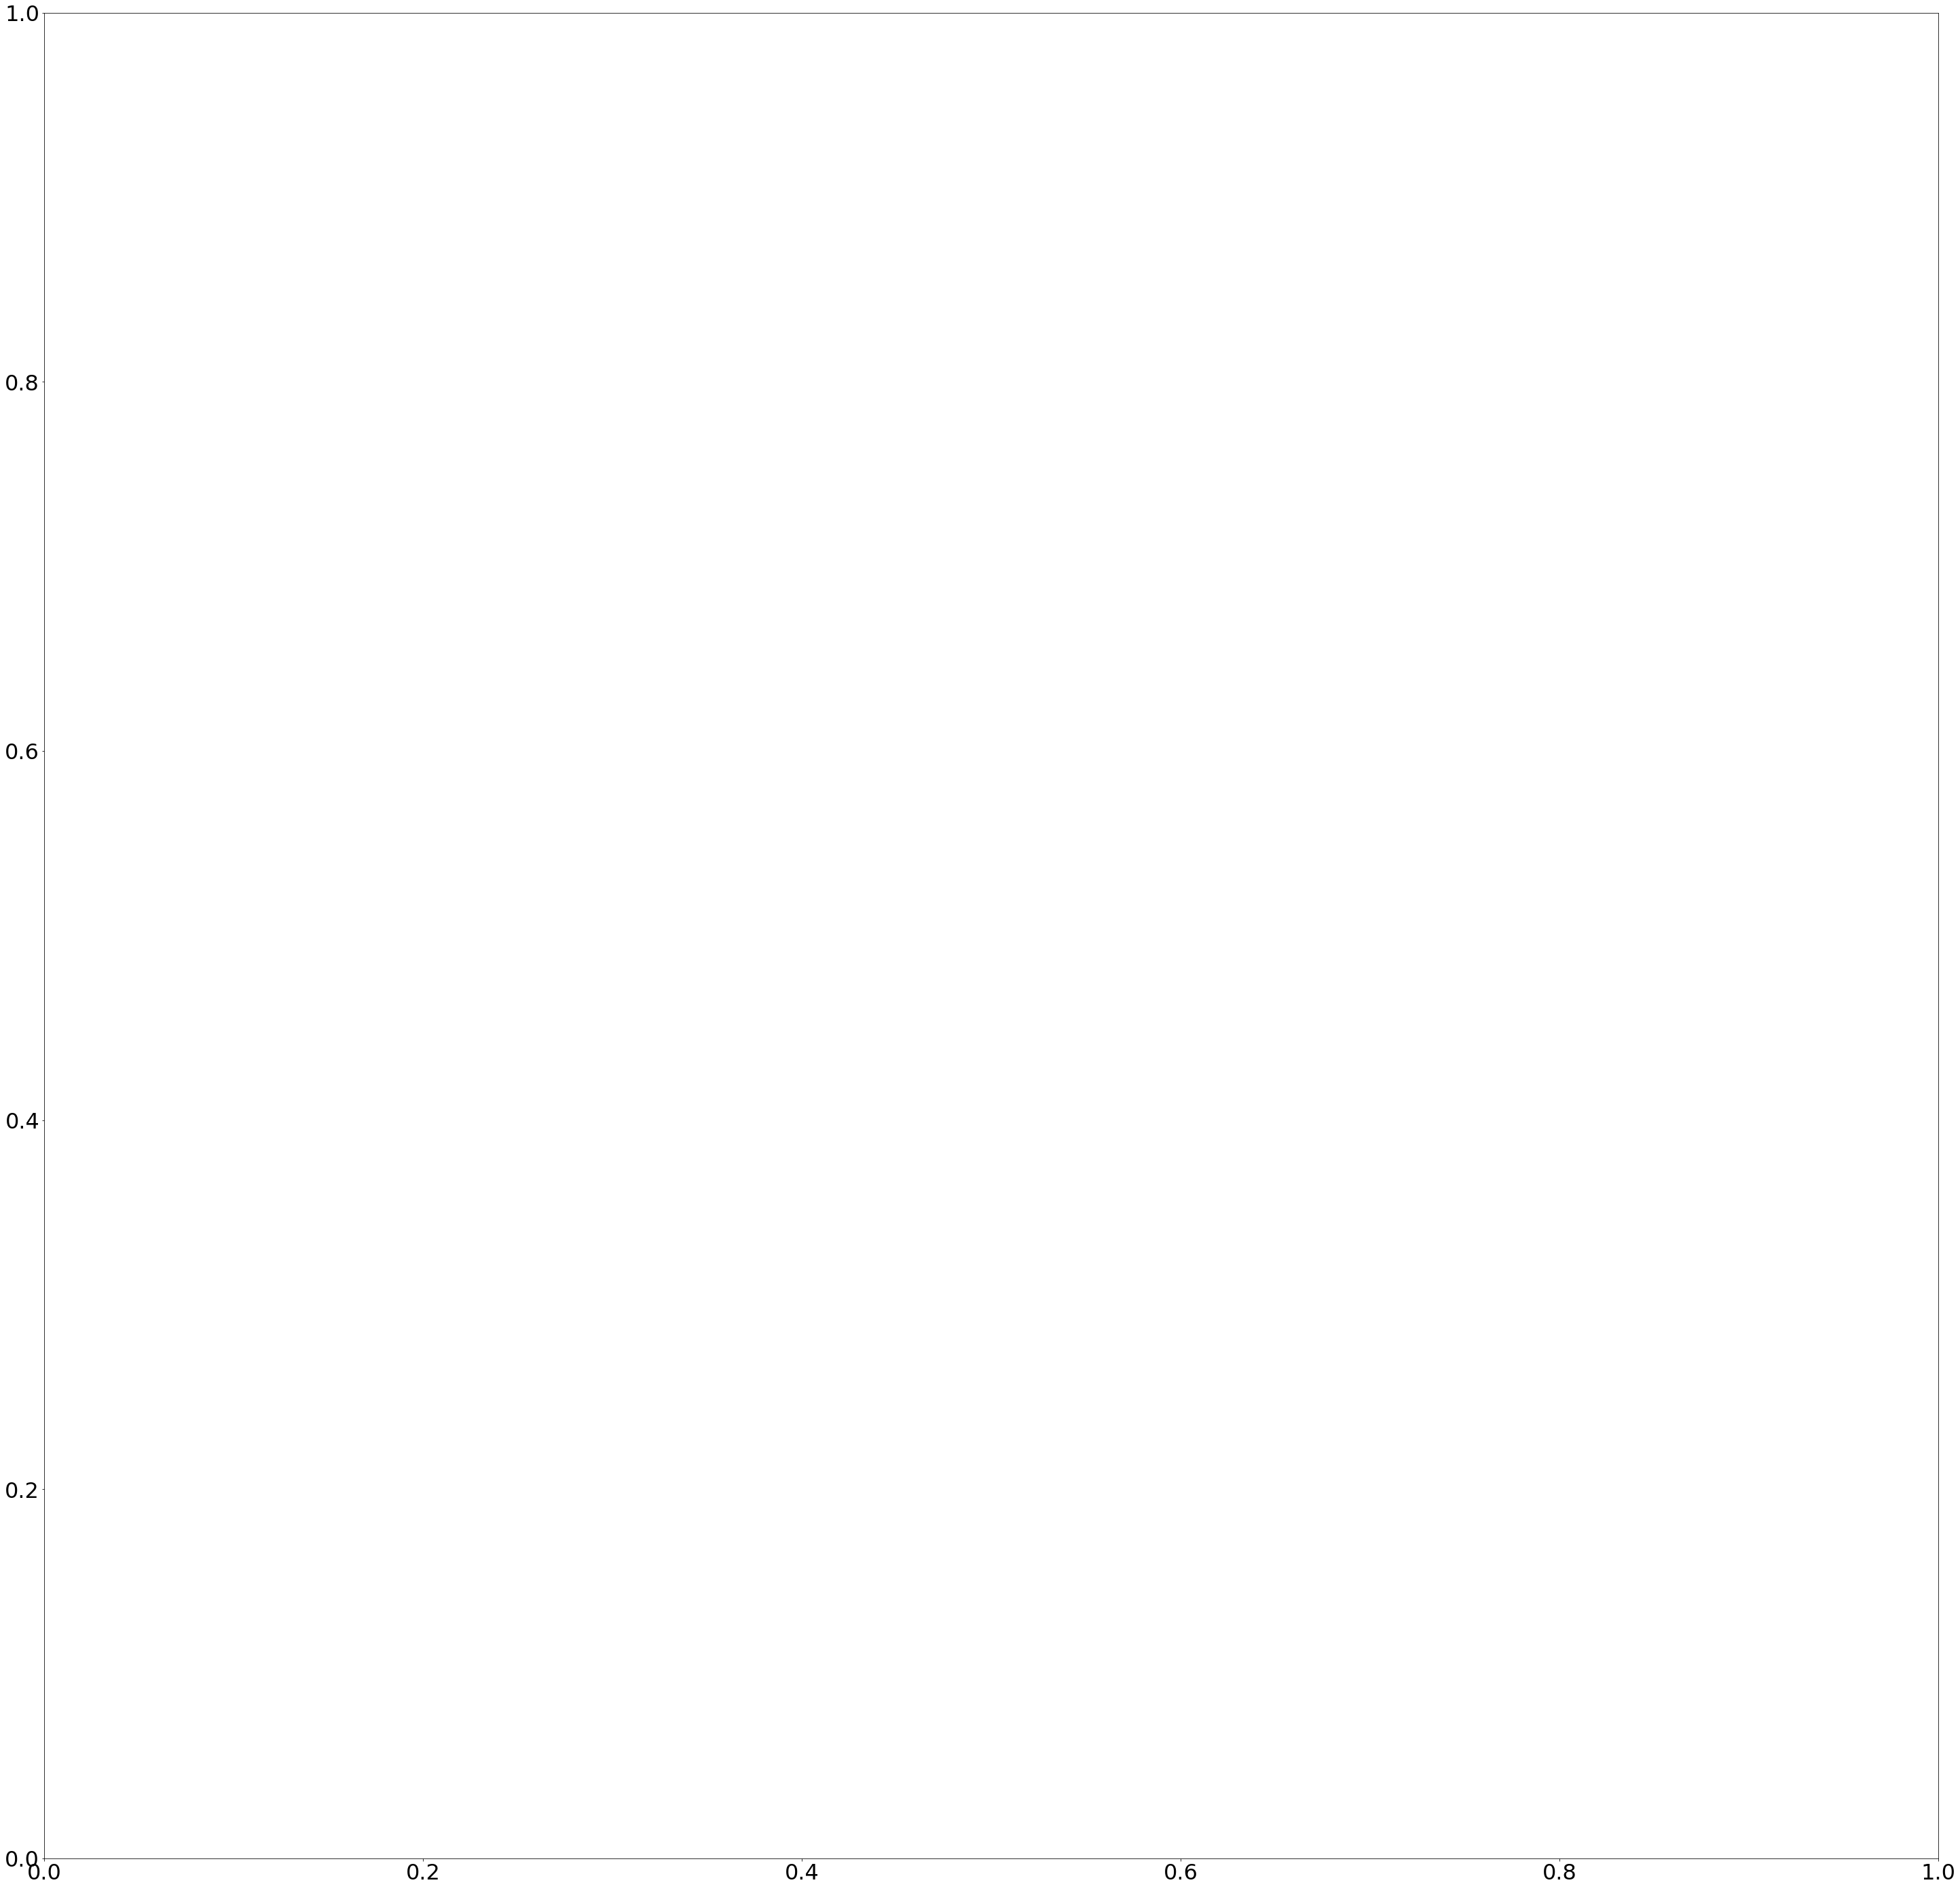

In [13]:
plt.rcParams["figure.figsize"] = (50,50)
plt.rcParams["font.size"] = 32.0
plt.plot(pre_garmin_edited.Date, pre_garmin_edited.Mileage)
plt.show()

# Garmin Data Wrangling

# Future Garmin Data Web Scraping

In [ ]:
!pip install requests

In [ ]:
!pip install beautifulsoup4

In [ ]:
import numpy as np
import pandas as pd
import requests
import bs4
import lxml.etree as xml

In [ ]:
URL = "https://connect.garmin.com/modern/activities"

requests.get(URL)

<Response [200]>

In [ ]:
requests.get(URL, {}).text

In [ ]:
web_page = bs4.BeautifulSoup(requests.get(URL, {}).text, "lxml")

In [ ]:
web_page

In [ ]:
web_page.head.title

<title data-react-helmet="true">Garmin Connect | </title>

In [ ]:
web_page.body

<body><noscript id="gatsby-noscript">This app works best with JavaScript enabled.</noscript><div id="___gatsby"><div role="group" style="outline:none" tabindex="-1"><div><header class="c017"><h1 class="c0116 c0118"><a class="c018" href="/" title="Connect"></a></h1><div class="c0114"></div></header><main class="c014 c016"><div class="c013"><div class="c011"><div class="c012" id="gauth-widget"><noscript>To sign in to your Garmin account, please enable JavaScript in your web browser.</noscript></div></div><div id="loginGauth"></div></div></main><footer class="c0123"><div></div><div class="c0132"><span class="c0129 c0133"><a href="https://www.instagram.com/garminfitness/" title="Instagram"></a></span><span class="c0130 c0134"><a href="https://www.facebook.com/garminfit" title="Facebook"></a></span><span class="c0131 c0135"><a href="https://twitter.com/garminfitness" title="Twitter"></a></span></div><div id="consent"></div></footer></div></div></div><script id="gatsby-script-loader">/*<![CD

In [ ]:
sub_webpage = web_page.find_all(name="li") #, attrs={'class': 'list-item animated row-fluid'}

In [ ]:
sub_webpage

[]

I would like to make searchable notes that I could go through with links to exercises for injuries and such. It would be really useful to be able to have the types of injuries that I have gone through before and be able to just immediately have the stretches and such that worked. Then I can the next time find out how that went and then adjust based upon the previous injury timeline and see what works best for recovery for me. 